In [194]:
import numpy as np
from scipy.integrate import odeint
import math
import random
import time
import matplotlib
matplotlib.rcParams.update({'font.size': 25})
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
import matplotlib.pyplot as plt

In [195]:
d_m=math.log(2)/5
d_p=math.log(2)/600
B=0.1
R=1
T=1
factor=2 #conv sec to min
features={
    #RNAP binding free energy, kcal/mol
    'dG_RNAP':{"offtarget":-4*R,
                 "Phlf":-4.7*R,
                 "Srpr":-4.4*R,
                 "BetI":-4.7*R,#
                 "HlyllR":-4.7*R,
                 "AmtR":-4.8*R,
                 "LacI":-4.5*R,#
                 "TetR":-4.7*R,#
                 "AraC":-4.5*R,#
                 "Con_A":-4*R,#
                 "Con_I":-4*R,#
                 "KanR":-4*R,#
                 "StrepR":-4*R#
                },#tbd
    #TF binding free energy, kcal/mol
    'dG_TF':{"offtarget":-4*T,
                 "Phlf":-9*T,
                 "Srpr":-7.5*T,
                 "BetI":-8*T,#
                 "HlyllR":-6.5*T,
                 "AmtR":-9*T,
                 "TetR":-7.5*T,#
                 "AraC":-8*T,#
                 "LacI":-8*T#
                }, #tbd
    #inactive binding free energy
    'dG_Inactive':{'TetR':-2.0,#
                  'LacI':-2.0,#
                  'AraC':-2.0},#
    #mRNA deg rate, 1/min
    'd_mRNA':{"Phlf":d_m,#
                  "Srpr":d_m,#
                  "BetI":d_m,#
                  "HlyllR":d_m,#
                  "AmtR":d_m,#
                  "YFP":d_m,#
                  "LacI_TetR":d_m,#
                  "AraC":d_m,#
                  "KanR":d_m,#
                  "StrepR":d_m #
                }, #tbd github/cidarlab?
    #Translation rate, protein/mRNA/min
    'beta':{"Phlf":1,#
                  "Srpr":1,#
                  "BetI":1,#
                  "HlyllR":1,#
                  "AmtR":1,#
                  "YFP":1,#
                  "LacI":1,#
                  "AraC":1,#
                  "TetR":1,#
                  "KanR":1,#
                  "StrepR":1#
                },
#TIRS from RBS calc converted to proteins/mrna/min
 #   'beta':{"Phlf":0.36*B,#
 #                 "Srpr":5*B,#
 #                 "BetI":1.6*B,#
 #                 "HlyllR":0.13*B,#
 #                 "AmtR":1.35*B,#
 #                 "YFP":0.28*B,#
 #                 "LacI":44*B,#
 #                 "AraC":32*B,#
 #                 "TetR":61*B,#
 #                 "KanR":37*B,#
 #                 "StrepR":0.24*B#
 #               },
    #number of TF binding sites in promoter
    'N_ontarget':{"Phlf":5,#
                  "Srpr":10,#
                  "BetI":10,#
                  "HlyllR":20,#
                  "AmtR":5,#
                  "LacI":10,#
                  "TetR":10,#
                  "AraC":20,#
                }, #tbd
    # number of free RNAP
    'N_RNAP':750,#
    # number of free Ribosomes
    'N_RIBO':1000, #
    #protein deg rates, 1/min
    'd_Protein':{"Phlf":d_p,#
                  "Srpr":d_p,#
                  "BetI":d_p,#
                  "HlyllR":d_p,#
                  "AmtR":d_p,#
                  "YFP":d_p,#
                  "LacI":d_p,#
                  "AraC":d_p,#
                  "TetR":d_p,#
                  "KanR":d_p,#
                  "StrepR":d_p#
                }, #tbd
    #growth rate, 1/min
    'mu':math.log(2)/45, #tbd
    #max promoter transcription rate mRNA/promoter/min
    'a_max':{"Phlf":3*factor,
                  "Srpr":3*factor,
                  "BetI":1.7*factor,#
                  "HlyllR":2.5*factor,
                  "AmtR":1.5*factor,
                  "LacI":2*factor,#
                  "TetR":3*factor,#
                  "AraC":2*factor,#
                  "Con_A":1*factor,
                  "Con_I":1*factor,
                  "KanR":2*factor,
                  "StrepR":2*factor
                },
    #genome length
    'genome_len':4600000,
    #copy number of circuit    
    "copy_number":{"Phlf":10,
                  "Srpr":10,
                  "BetI":10,
                  "HlyllR":10,
                  "AmtR":10,
                  "YFP":5,
                  "LacI_TetR":10,
                  "AraC":10,
                  "KanR":10,
                  "StrepR":5},
    
    #inducer concentrations used mM
    'inducers':{'AraC':0,
                'TetR':0,
                'LacI':0
                },
    #kd of inducers
    'iKd':{'AraC': 0.05,#
           'LacI': 0.05,#
           'TetR':0.005 #
                },
    # temperature
    'T':310,
    
    'co_op':{"Phlf":1,#
                  "Srpr":1,#
                  "BetI":1,#
                  "HlyllR":1,#
                  "AmtR":1,#
                  "LacI":1,#
                  "TetR":1,#
                  "AraC":2,}
    
    }

#cooperativity
#    'co_op':{'AraC':2,#
#             'LacI':2,#
#             'TetR':2#
#                },
#kd for hill functions
#'Kd':{'AraC':5,#
#          'LacI':5,#
#          'TetR':5}

In [196]:
def Partition_fxn(a_max,dG_RNAP,N_RNAP,dG_TFoff,dG_Active,dG_Inactive, 
                  N_Bindingsites,cooperativity,N_Repressors,fractionActive,genome_len,T):
    RT=T*1.987/1000 #temperature(kelvin)*R(kcal/K/mol)

    P_RNAP=N_RNAP*math.exp(-dG_RNAP/RT)/genome_len
    P_Active=((1 + N_Repressors * fractionActive * math.exp(- (dG_Active)) / genome_len)**N_Bindingsites) - 1
    P_Inactive=((1 + N_Repressors * (1 - fractionActive) * math.exp(-(dG_Inactive)) / genome_len)**N_Bindingsites) -1;
    
    if cooperativity>1:
        Pbound=P_RNAP / (1 + P_RNAP + cooperativity*(P_Active + P_Inactive)+(P_Active + P_Inactive)**cooperativity)
    else:
        Pbound=P_RNAP / (1 + P_RNAP + (P_Active + P_Inactive))
    alpha=a_max*Pbound
    return alpha

def Hill_function_R(a_max,Kd,cooperativity,N_Repressor):
    alpha = a_max/(1 + (N_Repressor/Kd)**cooperativity);
    return alpha

def Hill_function_A(a_max,Ka,cooperativity,N_Activator):
    alpha = a_max*((N_Activator)**cooperativity)/(Ka**cooperativity + (N_Repressor)**cooperativity);
    return alpha

In [197]:
def rule_30_circuit(y,t,features):
    n_strep=y[0]
    m_strep=y[1]
    p_strep=y[2]
    
    n_kan=y[3]
    m_kan=y[4]
    p_kan=y[5]
    
    n_ara=y[6]
    m_ara=y[7]
    p_ara=y[8]
    
    n_lac=y[9]
    m_lac=y[10]
    p_lac=y[11]
    p_tet=y[12]
    
    n_Phlf=y[13]
    m_Phlf=y[14]
    p_Phlf=y[15]
    
    n_Srpr=y[16]
    m_Srpr=y[17]
    p_Srpr=y[18]
    
    n_BetI=y[19]
    m_BetI=y[20]
    p_BetI=y[21]

    n_HlyllR=y[22]
    m_HlyllR=y[23]
    p_HlyllR=y[24]
    
    n_AmtR=y[25]
    m_AmtR=y[26]
    p_AmtR=y[27]
    
    n_YFP=y[28]
    m_YFP=y[29]
    p_YFP=y[30]
    
    fractionActive_ara=1/(1+features["inducers"]["AraC"]/features['iKd']['AraC']) 
    fractionActive_lac=1/(1+features["inducers"]["LacI"]/features['iKd']['LacI'])
    fractionActive_tet=1/(1+features["inducers"]["TetR"]/features['iKd']['TetR'])
    
    #print fractionActive_lac
    
    alpha_strep=Partition_fxn(features['a_max']['StrepR'],features['dG_RNAP']['StrepR'],features['N_RNAP'],0,0,0, 
                  0,0,0,0,features['genome_len'],features['T'])
    alpha_kan=Partition_fxn(features['a_max']['KanR'],features['dG_RNAP']['KanR'],features['N_RNAP'],0,0,0, 
                  0,0,0,0,features['genome_len'],features['T'])
    alpha_con_a=Partition_fxn(features['a_max']['Con_A'],features['dG_RNAP']['Con_A'],features['N_RNAP'],0,0,0, 
                  0,0,0,0,features['genome_len'],features['T'])
    alpha_con_L_T=Partition_fxn(features['a_max']['Con_I'],features['dG_RNAP']['Con_I'],features['N_RNAP'],0,0,0, 
                  0,0,0,0,features['genome_len'],features['T'])
    alpha_ara=Partition_fxn(features['a_max']['AraC'],features['dG_RNAP']['AraC'],features['N_RNAP'],features['dG_TF']['offtarget'],features['dG_TF']['AraC'],features['dG_Inactive']['AraC'], 
                  features['N_ontarget']['AraC'],features['co_op']['AraC'],p_ara,fractionActive_ara,features['genome_len'],features['T'])
    alpha_tet=Partition_fxn(features['a_max']['TetR'],features['dG_RNAP']['TetR'],features['N_RNAP'],features['dG_TF']['offtarget'],features['dG_TF']['TetR'],features['dG_Inactive']['TetR'], 
                  features['N_ontarget']['TetR'],features['co_op']['TetR'],p_tet,fractionActive_tet,features['genome_len'],features['T'])
    alpha_lac=Partition_fxn(features['a_max']['LacI'],features['dG_RNAP']['LacI'],features['N_RNAP'],features['dG_TF']['offtarget'],features['dG_TF']['LacI'],features['dG_Inactive']['LacI'], 
                  features['N_ontarget']['LacI'],features['co_op']['LacI'],p_lac,fractionActive_lac,features['genome_len'],features['T'])
    alpha_Phlf=Partition_fxn(features['a_max']['Phlf'],features['dG_RNAP']['Phlf'],features['N_RNAP'],features['dG_TF']['offtarget'],features['dG_TF']['Phlf'],0, 
                  features['N_ontarget']['Phlf'],features['co_op']['Phlf'],p_Phlf,1,features['genome_len'],features['T'])
    alpha_Srpr=Partition_fxn(features['a_max']['Srpr'],features['dG_RNAP']['Srpr'],features['N_RNAP'],features['dG_TF']['offtarget'],features['dG_TF']['Srpr'],0, 
                  features['N_ontarget']['Srpr'],features['co_op']['Srpr'],p_Srpr,1,features['genome_len'],features['T'])
    alpha_BetI=Partition_fxn(features['a_max']['BetI'],features['dG_RNAP']['BetI'],features['N_RNAP'],features['dG_TF']['offtarget'],features['dG_TF']['BetI'],0, 
                  features['N_ontarget']['BetI'],features['co_op']['BetI'],p_BetI,1,features['genome_len'],features['T'])
    alpha_AmtR=Partition_fxn(features['a_max']['AmtR'],features['dG_RNAP']['AmtR'],features['N_RNAP'],features['dG_TF']['offtarget'],features['dG_TF']['AmtR'],0, 
                  features['N_ontarget']['AmtR'],features['co_op']['AmtR'],p_AmtR,1,features['genome_len'],features['T'])
    alpha_HlyllR=Partition_fxn(features['a_max']['HlyllR'],features['dG_RNAP']['HlyllR'],features['N_RNAP'],features['dG_TF']['offtarget'],features['dG_TF']['HlyllR'],0, 
                  features['N_ontarget']['HlyllR'],features['co_op']['HlyllR'],p_HlyllR,1,features['genome_len'],features['T'])
    
    #print alpha_HlyllR
    
    dy=np.zeros(len(y))
    
    dy[0]=0
    dy[1]=alpha_strep*n_strep-features['d_mRNA']['StrepR']*m_strep-features['mu']*m_strep
    dy[2]=features['beta']['StrepR']*m_strep-features['d_Protein']['StrepR']*p_strep-features['mu']*p_strep

    dy[3]=0
    dy[4]=alpha_kan*n_kan-features['d_mRNA']['KanR']*m_kan-features['mu']*m_kan
    dy[5]=features['beta']['KanR']*m_kan-features['d_Protein']['KanR']*p_kan-features['mu']*p_kan
                                                                                    
    dy[6]=0
    dy[7]=alpha_con_a*n_ara-features['d_mRNA']['AraC']*m_ara-features['mu']*m_ara
    dy[8]=features['beta']['AraC']*m_ara-features['d_Protein']['AraC']*p_ara-features['mu']*p_ara
    
    dy[9]=0
    dy[10]=alpha_con_L_T*n_lac-features['d_mRNA']['LacI_TetR']*m_lac-features['mu']*m_lac
    dy[11]=features['beta']['LacI']*m_lac-features['d_Protein']['LacI']*p_lac-features['mu']*p_lac

    dy[12]=features['beta']['TetR']*m_lac-features['d_Protein']['TetR']*p_tet-features['mu']*p_tet
                                                                                    
    dy[13]=0
    dy[14]=(alpha_Srpr+alpha_BetI)*n_Phlf-features['d_mRNA']['Phlf']*m_Phlf-features['mu']*m_Phlf
    dy[15]=features['beta']['Phlf']*m_Phlf-features['d_Protein']['Phlf']*p_Phlf-features['mu']*p_Phlf
    
    dy[16]=0
    dy[17]=alpha_ara*n_Srpr-features['d_mRNA']['Srpr']*m_Srpr-features['mu']*m_Srpr
    dy[18]=features['beta']['Srpr']*m_Srpr-features['d_Protein']['Srpr']*p_Srpr-features['mu']*p_Srpr

    dy[19]=0
    dy[20]=alpha_HlyllR*n_BetI-features['d_mRNA']['BetI']*m_BetI-features['mu']*m_BetI
    dy[21]=features['beta']['BetI']*m_BetI-features['d_Protein']['BetI']*p_BetI-features['mu']*p_BetI
                                                                        
    dy[22]=0
    dy[23]=(alpha_tet+alpha_lac)*n_HlyllR-features['d_mRNA']['HlyllR']*m_HlyllR-features['mu']*m_HlyllR
    dy[24]=features['beta']['HlyllR']*m_HlyllR-features['d_Protein']['HlyllR']*p_HlyllR-features['mu']*p_HlyllR

    dy[25]=0
    dy[26]=(alpha_ara+alpha_HlyllR)*n_AmtR-features['d_mRNA']['AmtR']*m_AmtR-features['mu']*m_AmtR
    dy[27]=features['beta']['AmtR']*m_AmtR-features['d_Protein']['AmtR']*p_AmtR-features['mu']*p_AmtR
    
    dy[28]=0
    dy[29]=(alpha_Phlf+alpha_AmtR)*n_YFP-features['d_mRNA']['YFP']*m_YFP-features['mu']*m_YFP
    dy[30]=features['beta']['YFP']*m_YFP-features['d_Protein']['YFP']*p_YFP-features['mu']*p_YFP
    
    return dy

In [213]:
# Plots the solution to circuit model
def circuit_char(time_points, solution):
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(24, 24))
    
    ax1.set_ylim((0, 200))
    ax2.set_ylim((0, 2000))
    ax3.set_ylim((0, 500))
    ax4.set_ylim((0, 10000))

    
    ax1.set_title('YFP mRNA levels')
    ax1.plot(time_points, solution[:, 29], 'orange')
    ax1.set_xlabel('Time (minutes)')
    ax1.set_ylabel('mRNAs')

    ax2.set_title('YFP protein levels')
    ax2.plot(time_points, solution[:, 30], 'orange')
    ax2.set_xlabel('Time (minutes)')
    ax2.set_ylabel('Proteins')
    
    ax3.set_title('TF mRNA levels')
    ax3.plot(time_points, solution[:, 14], 'r')
    ax3.plot(time_points, solution[:, 17], 'y')
    ax3.plot(time_points, solution[:, 20], 'g')
    ax3.plot(time_points, solution[:, 23], 'b')
    ax3.plot(time_points, solution[:, 26], 'm')
    ax3.legend(['Phlf', 'Srpr', 'BetI','HlyllR', 'AmtR'])
    ax3.set_xlabel('Time (minutes)')
    ax3.set_ylabel('mRNAs')

    ax4.set_title('TF protein levels')
    ax4.plot(time_points, solution[:, 15], 'r')
    ax4.plot(time_points, solution[:, 16], 'y')
    ax4.plot(time_points, solution[:, 21], 'g')
    ax4.plot(time_points, solution[:, 24], 'b')
    ax4.plot(time_points, solution[:, 27], 'm')
    ax4.legend(['Phlf', 'Srpr', 'BetI','HlyllR', 'AmtR'])
    ax4.set_xlabel('Time (minutes)')
    ax4.set_ylabel('Proteins')

    fig.subplots_adjust(hspace=0.5)

    plt.show()

In [214]:
# Solves circuit model function
def solve_circuit(induction_conditions,features):
    
    t = np.linspace(0, 300, 1000)

    h0 = np.zeros(31)
    h0[0]=features['copy_number']['StrepR']
    h0[3]=features['copy_number']['KanR']
    h0[6]=features['copy_number']['AraC']
    h0[9]=features['copy_number']['LacI_TetR']
    h0[13]=features['copy_number']['Phlf']
    h0[16]=features['copy_number']['Srpr']
    h0[19]=features['copy_number']['BetI']
    h0[22]=features['copy_number']['HlyllR']
    h0[25]=features['copy_number']['AmtR']
    h0[28]=features['copy_number']['YFP']
    
    features['inducers']['LacI']=0
    features['inducers']['TetR']=0
    features['inducers']['AraC']=0
    
    y = odeint(rule_30_circuit, h0, t, (features,))

    # circuit_char(t, y)

    h0=y[-1,:]

    # induction
    
    features['inducers']['LacI']=induction_conditions[0]
    features['inducers']['TetR']=induction_conditions[1]
    features['inducers']['AraC']=induction_conditions[2]
    
    y = odeint(rule_30_circuit, h0, t, (features,))

    circuit_char(t, y)
                                                  
#solve_circuit([0,0,0],features)
#print "done!"

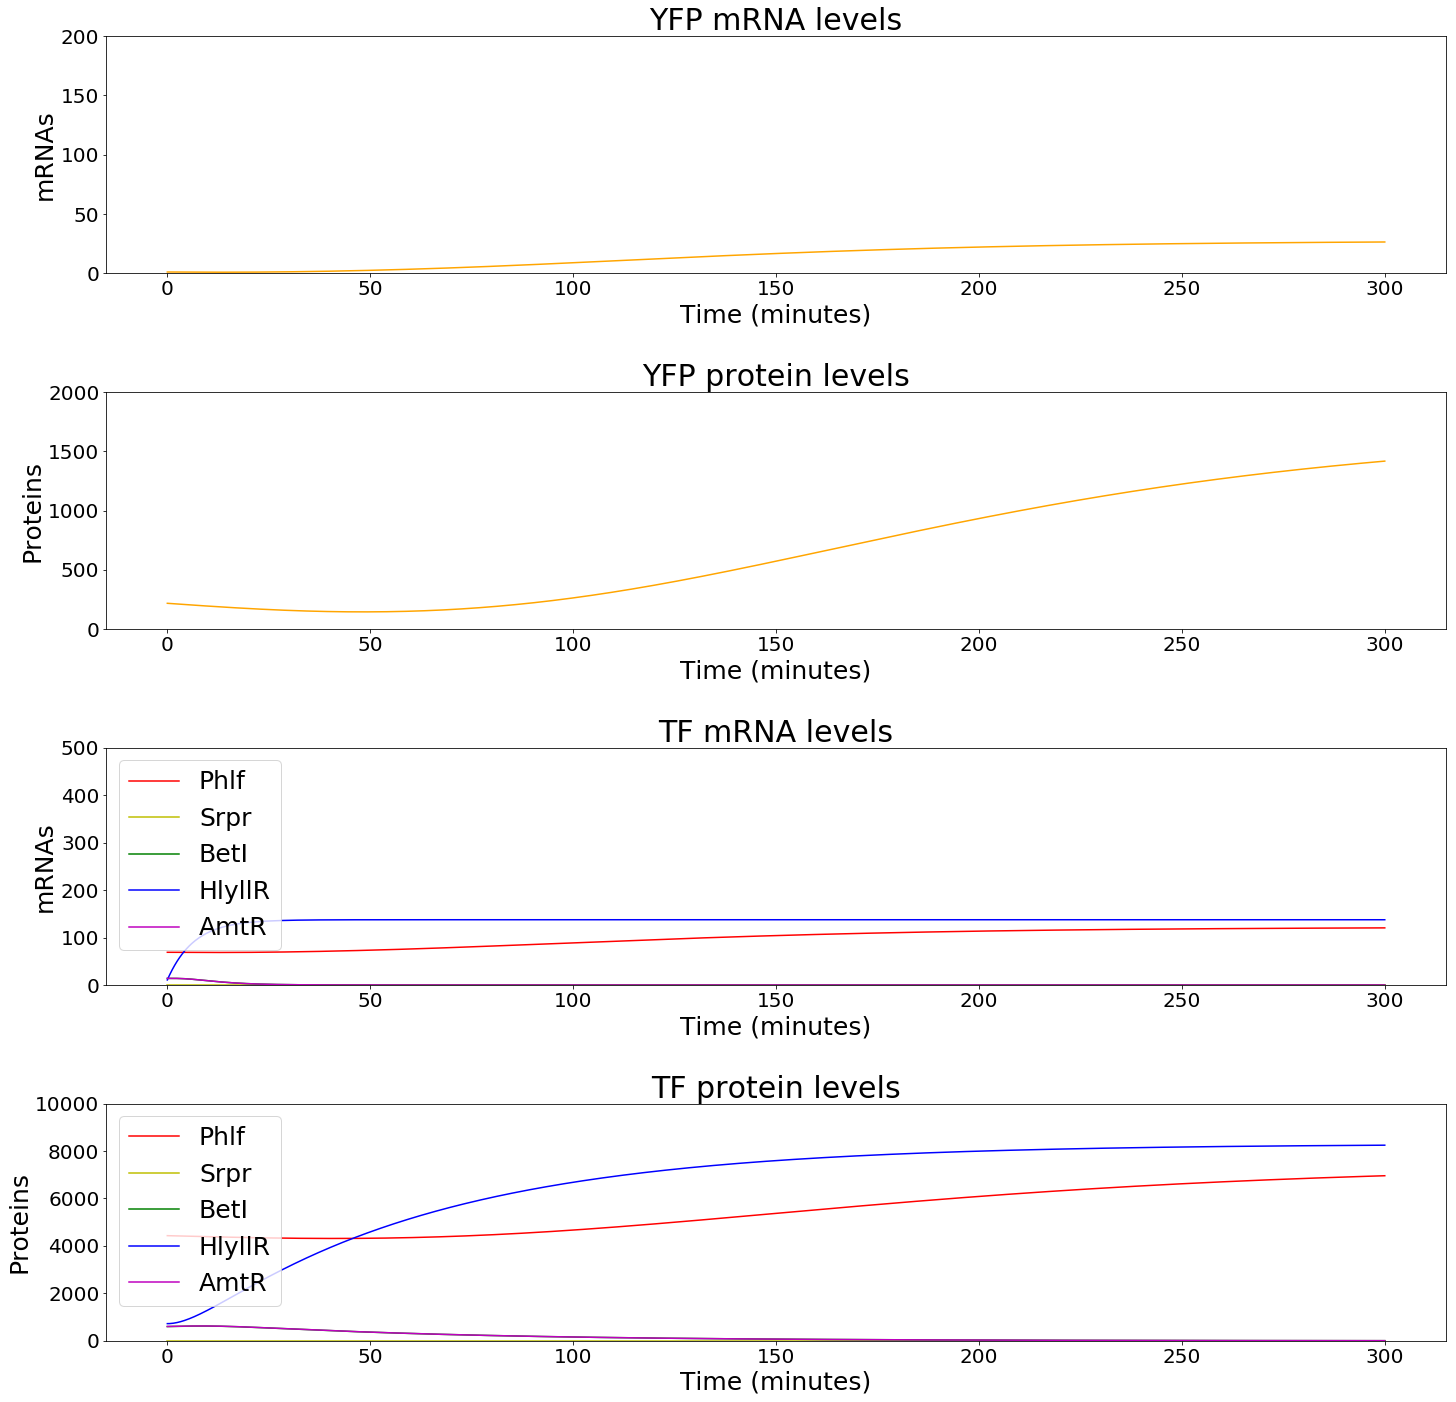

done!


In [215]:
%matplotlib inline
matplotlib.rcParams.update({'font.size': 25})
solve_circuit([1,1,0],features)
print "done!"

In [203]:
def calc_Pt_number_serial(features, this_element, ups_element, trans_coupling):
    N=features['copy_number'][trans_coupling]
    a=features['a_max'][ups_element]    
    # print a
    D=features['N_ontarget'][this_element]
    dGR=float(features['dG_TF'][this_element])
    # print dGR
    B=features['beta'][this_element]
    d_m=features['d_mRNA'][trans_coupling]
    d_p=features['d_Protein'][this_element]
    # print 1/(d_m*d_p)
    u=features['mu']
    LG=features['genome_len']
    T=310
    RT=T*1.987/1000 #temperature(kelvin)*R(kcal/K/mol)
    # print RT
    R=a*B*N/((d_m+u)*(d_p+u))
    # print R
    # print math.exp(-dGR/RT)
    Pt=N*(math.exp(-dGR/RT)/LG)*R/(1+N*D*(math.exp(-dGR/RT)/LG))
    return Pt

In [9]:
dependency_graph = {
    "Phlf"  : (["BetI", "Srpr"], "Phlf"),
    "Srpr"  : (["AraC"], "Srpr"),
    "BetI"  : (["HlyllR"], "BetI"),
    "HlyllR": (["LacI", "TetR"], "HlyllR"),
    "AmtR"  : (["AraC", "HlyllR"], "AmtR")
}

In [10]:
from collections import defaultdict

In [11]:
ptashne_graph = defaultdict(lambda : defaultdict(int))

for this_element in dependency_graph:
    trans_coupling = dependency_graph[this_element][1]
    for ups_element in dependency_graph[this_element][0]:
        ptashne_graph[this_element][ups_element] = calc_Pt_number_serial(features, this_element, ups_element, trans_coupling)        